In [1]:
# **Step 2: The Python Script (`train_snake.py`)**

import sys
sys.path.insert(0, '..')  # Add parent directory to path

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import elastica as ea
from collections import defaultdict
from typing import Optional
from numpy.typing import NDArray
# from PyElastica.elastica.timestepper.symplectic_steppers import do_step
# from PyElastica.elastica.timestepper import extend_stepper_interface
from elastica.typing import RodType


from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

import matplotlib.pyplot as plt

import os
import json
from pathlib import Path

from snake_env import FixedWavelengthXZOnlyContinuumSnakeEnv
import config

In [2]:
from Utilities.visualization import visualization

v1 = visualization()



In [3]:
# Reload config module to get latest changes
import importlib
importlib.reload(config)

config.ENV_CONFIG["_n_elem"] = 10

env = FixedWavelengthXZOnlyContinuumSnakeEnv(
    fixed_wavelength=config.ENV_CONFIG["fixed_wavelength"],
    obs_keys=config.ENV_CONFIG["obs_keys"],
)

# Configure environment parameters
env.period = config.ENV_CONFIG["period"]
env.ratio_time = config.ENV_CONFIG["ratio_time"]
env.rut_ratio = config.ENV_CONFIG["rut_ratio"]
env._n_elem = config.ENV_CONFIG["_n_elem"]
env.max_episode_length = config.ENV_CONFIG["max_episode_length"]*100
env.reward_weights = config.REWARD_WEIGHTS

obs, _ = env.reset()

In [4]:
env._n_elem

10

In [6]:
# Get the project root directory (parent of 'developing')
# Since this notebook is in the 'developing' folder, go up one level to get project root
current_dir = Path.cwd()
if current_dir.name == 'developing':
    project_root = current_dir.parent
else:
    project_root = current_dir

model_path = project_root / "Training" / "Saved_Models" / "PPO_Snake_Model"


In [8]:

print(f"\nLoading model from {model_path}...")
if not model_path.with_suffix('.zip').exists():
    print(f"Error: Model file not found at {model_path}.zip")
else:
    model = PPO.load(str(model_path), env=env)
    print("Model loaded successfully!")



Loading model from /Users/wenqifan/Desktop/RL-ElasticaSnake/Training/Saved_Models/PPO_Snake_Model...
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded successfully!


In [6]:
import contextlib
import io

# Configuration
num_steps = 100  # Number of steps to run
use_model = True  # Set to True to use model.predict(), False to use manual actions
verbose = True  # Set to True to print step-by-step information

# Manual action (used when use_model=False)
# Action space is normalized to [-1, 1]
manual_action = np.array([5e-3,5e-3,5e-3,5e-3,5e-3,5e-3], dtype=np.float32)

# Reset environment
obs, _ = env.reset()

# Tracking variables
total_reward = 0.0
episode_reward = 0.0
episode_count = 0

print(f"Running {num_steps} steps in environment...")
print(f"Mode: {'Model predictions' if use_model else 'Manual actions'}")
if not use_model:
    print(f"Manual action: {manual_action}")
print("=" * 70)


Running 100 steps in environment...
Mode: Model predictions


In [7]:

# Main loop
for step in range(num_steps):
    
    # action, _states = model.predict(obs, deterministic=True)

    action = manual_action.copy()
    
    # Step environment (suppress stdout from elastica)
    with contextlib.redirect_stdout(io.StringIO()):
        obs, reward, terminated, truncated, info = env.step(action)
    
    # Accumulate rewards
    total_reward += reward
    episode_reward += reward
    
    # Print step information
    if verbose:
        current_time = info.get('current_time', 0.0)
        position = info.get('position', [0.0, 0.0, 0.0])
        forward_speed = info.get('forward_speed', info.get('velocity_projection', 0.0))
        lateral_speed = info.get('lateral_speed', info.get('speed_perpendicular_to_target', 0.0))
        
        print(f"Step {step+1}/{num_steps} | "
              f"Time: {current_time:.3f}s | "
              f"Reward: {reward:.4f} | "
              f"Pos: [{position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f}] | "
              f"Forward: {forward_speed:.4f} m/s | "
              f"Lateral: {lateral_speed:.4f} m/s")
    
    # Check if episode ended
    if terminated or truncated:
        episode_count += 1
        if verbose:
            print(f"\nEpisode {episode_count} ended at step {step+1}")
            print(f"  Episode reward: {episode_reward:.4f}")
            print(f"  Final position: {info.get('position', [0, 0, 0])}")
        obs, _ = env.reset()
        episode_reward = 0.0
        if verbose:
            print("Environment reset\n")

# Print summary
print("\n" + "=" * 70)
print("Evaluation Summary:")
print(f"  Total steps: {num_steps}")
print(f"  Episodes completed: {episode_count}")
print(f"  Total reward: {total_reward:.4f}")
print(f"  Average reward per step: {total_reward/num_steps:.4f}")
print("=" * 70)


Step 1/100 | Time: 0.011s | Reward: -6.9260 | Pos: [-0.000, 0.000, 0.175] | Forward: 0.0000 m/s | Lateral: 0.0000 m/s
Step 2/100 | Time: 0.022s | Reward: -4.7657 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0005 m/s | Lateral: 0.0000 m/s
Step 3/100 | Time: 0.033s | Reward: -3.1646 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0037 m/s | Lateral: 0.0000 m/s
Step 4/100 | Time: 0.044s | Reward: -2.2415 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0080 m/s | Lateral: 0.0000 m/s
Step 5/100 | Time: 0.055s | Reward: -1.9366 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0111 m/s | Lateral: 0.0000 m/s
Step 6/100 | Time: 0.066s | Reward: -3.6377 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0124 m/s | Lateral: 0.0000 m/s
Step 7/100 | Time: 0.077s | Reward: -5.8617 | Pos: [0.000, 0.000, 0.175] | Forward: 0.0105 m/s | Lateral: 0.0000 m/s
Step 8/100 | Time: 0.088s | Reward: -7.9396 | Pos: [0.000, 0.000, 0.176] | Forward: 0.0068 m/s | Lateral: 0.0000 m/s
Step 9/100 | Time: 0.099s | Reward: -9.7741 | Pos: [0.000, -0.0

In [11]:

# Visualize trajectory in 2D (X vs Z)
avg_positions = np.asarray(env.state_dict['avg_position'])
# v1.trajectory_2d(avg_positions[:, 0], avg_positions[:, 2])

# Visualize velocity norm history
avg_velocities = np.asarray(env.state_dict['avg_velocity'])
# v1.velocity_norm_history(env.state_dict['time'], avg_velocities)

# Visualize trajectory in 3D
# v1.trajectory_3d(avg_positions)

# v1.trajectory_2d(avg_positions[:, 0], avg_positions[:, 2])


In [12]:


# Prepare curvature data
# Curvature is stored as a list of arrays with shape (3, n_elem - 1)
if len(env.state_dict['curvature']) > 0:
    n_curvature_elements = env.state_dict['curvature'][0].shape[1]  # n_elem - 1
    # Sample up to 10 elements evenly along the snake
    n_samples = min(10, n_curvature_elements)
    if n_curvature_elements > 1:
        element_indices = np.linspace(0, n_curvature_elements - 1, n_samples, dtype=int)
    else:
        element_indices = [0]
    
    # Compute mean magnitude of curvature at each time step
    curvature_magnitudes_mean = []
    for kappa in env.state_dict['curvature']:
        # kappa has shape (3, n_elem - 1), compute magnitude for each element then take mean
        magnitude = np.mean(np.linalg.norm(kappa, axis=0))
        curvature_magnitudes_mean.append(magnitude)
    
    # Compute curvature magnitude for each sampled element
    curvature_by_element = {idx: [] for idx in element_indices}
    for kappa in env.state_dict['curvature']:
        # Compute magnitude for each element (shape: (n_elem - 1,))
        element_magnitudes = np.linalg.norm(kappa, axis=0)
        for idx in element_indices:
            curvature_by_element[idx].append(element_magnitudes[idx])
else:
    print("No curvature data available")


In [10]:
# Plot 1: Mean curvature over time
if len(env.state_dict['curvature']) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(env.state_dict['time'], curvature_magnitudes_mean, 
            color='black', linewidth=2)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Curvature Magnitude', fontsize=12)
    plt.title('Mean Curvature Over Time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No curvature data available")


NameError: name 'curvature_magnitudes_mean' is not defined

<Figure size 1200x600 with 0 Axes>

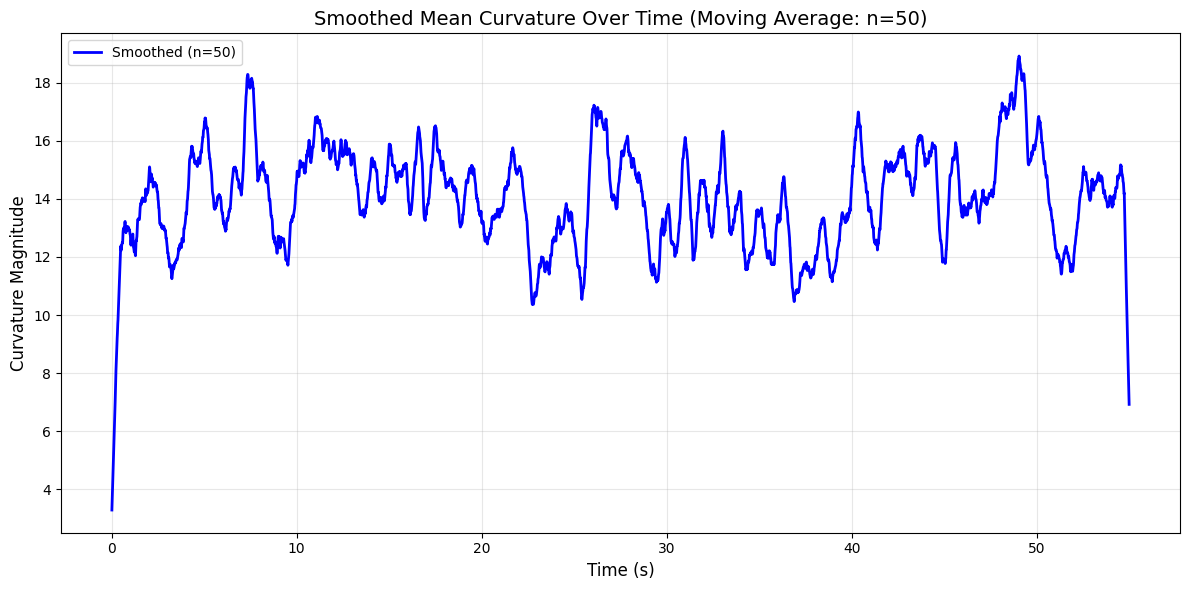

In [13]:
# Plot 3: Smoothed mean curvature over time (using moving average)
# Parameter n: number of data points to average over
n = 50  # Adjust this value to change the smoothing level (larger = smoother)

if len(env.state_dict['curvature']) > 0:
    # Compute smoothed mean curvature using moving average
    curvature_array = np.array(curvature_magnitudes_mean)
    
    # Apply moving average filter
    if len(curvature_array) >= n:
        # Create a uniform window for moving average
        kernel = np.ones(n) / n
        curvature_smoothed = np.convolve(curvature_array, kernel, mode='same')
    else:
        # If data is shorter than n, just use the original data
        curvature_smoothed = curvature_array
    
    # Plot smoothed mean curvature
    plt.figure(figsize=(12, 6))
    plt.plot(env.state_dict['time'], curvature_smoothed, 
            color='blue', linewidth=2, label=f'Smoothed (n={n})')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Curvature Magnitude', fontsize=12)
    plt.title(f'Smoothed Mean Curvature Over Time (Moving Average: n={n})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No curvature data available")


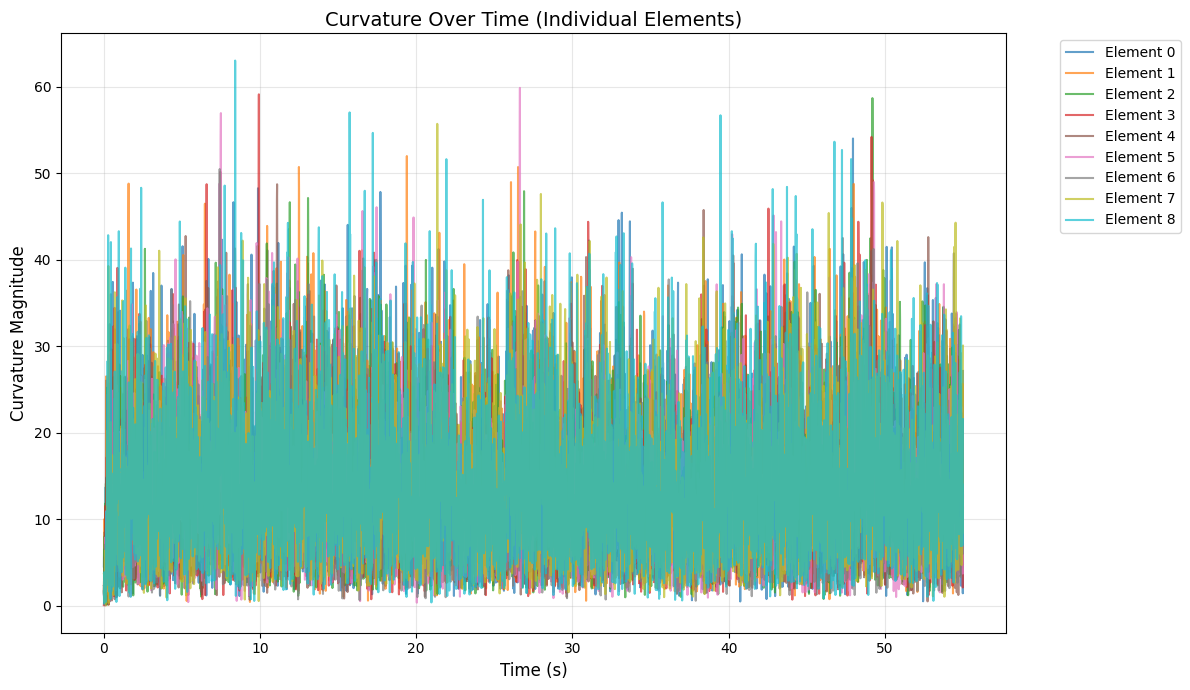

In [14]:
# Plot 2: Individual elements (up to 10) curvature over time
if len(env.state_dict['curvature']) > 0:
    plt.figure(figsize=(12, 7))
    
    # Plot individual elements
    colors = plt.cm.tab10(np.linspace(0, 1, len(element_indices)))
    for i, idx in enumerate(element_indices):
        plt.plot(env.state_dict['time'], curvature_by_element[idx], 
                label=f'Element {idx}', alpha=0.7, color=colors[i], linewidth=1.5)
    
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Curvature Magnitude', fontsize=12)
    plt.title('Curvature Over Time (Individual Elements)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No curvature data available")


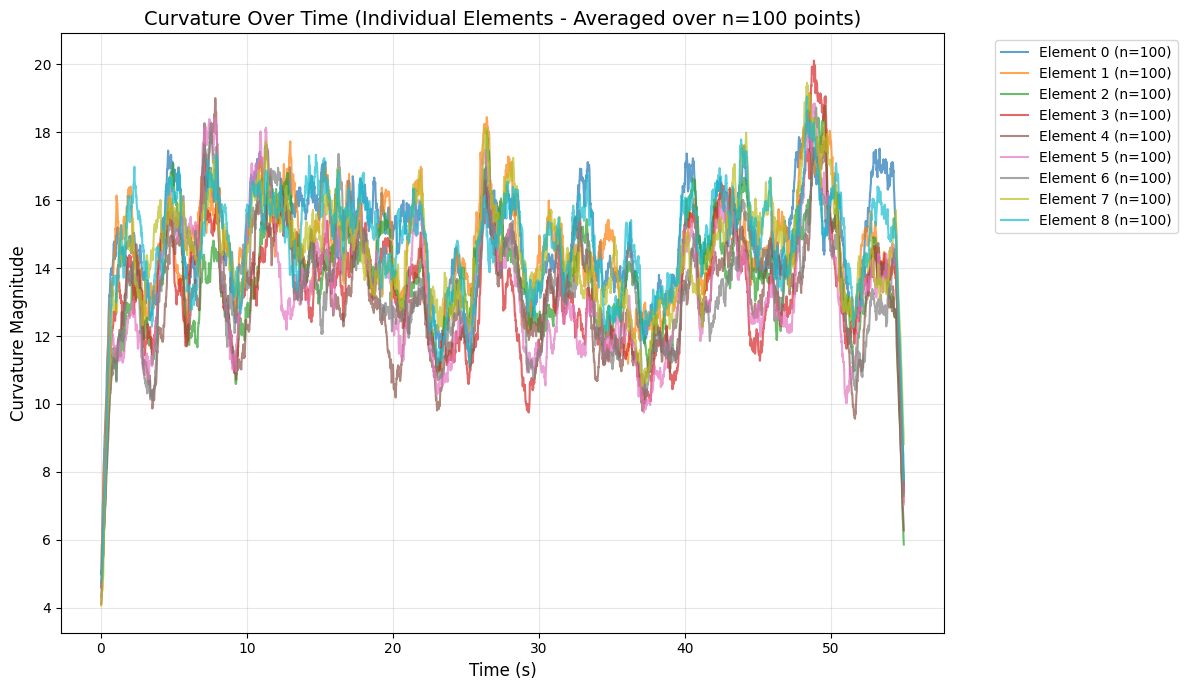

In [15]:
# Plot 4: Individual elements (up to 10) curvature over time - averaged over n data points
# Parameter n: number of data points to average over
n = 100  # Adjust this value to change the smoothing level (larger = smoother)

if len(env.state_dict['curvature']) > 0:
    plt.figure(figsize=(12, 7))
    
    # Plot smoothed individual elements
    colors = plt.cm.tab10(np.linspace(0, 1, len(element_indices)))
    for i, idx in enumerate(element_indices):
        # Get curvature data for this element
        curvature_array = np.array(curvature_by_element[idx])
        
        # Apply moving average filter
        if len(curvature_array) >= n:
            # Create a uniform window for moving average
            kernel = np.ones(n) / n
            curvature_smoothed = np.convolve(curvature_array, kernel, mode='same')
        else:
            # If data is shorter than n, just use the original data
            curvature_smoothed = curvature_array
        
        plt.plot(env.state_dict['time'], curvature_smoothed, 
                label=f'Element {idx} (n={n})', alpha=0.7, color=colors[i], linewidth=1.5)
    
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Curvature Magnitude', fontsize=12)
    plt.title(f'Curvature Over Time (Individual Elements - Averaged over n={n} points)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No curvature data available")



OSCILLATION AMPLITUDE ANALYSIS FOR EACH ELEMENT
Element    Mean            Peak-to-Peak    RMS Amplitude   Max             Min            
--------------------------------------------------------------------------------
0          14.947384       53.668206       7.990959        54.004166       0.335959       
1          14.612080       51.931429       7.793173        51.975531       0.044101       
2          13.799735       58.538607       7.453751        58.674250       0.135643       
3          13.426017       59.029161       7.290580        59.108416       0.079255       
4          13.269310       50.014557       7.109209        50.159856       0.145299       
5          13.469465       59.483511       7.402609        59.849602       0.366091       
6          13.575690       50.394146       7.222776        50.474624       0.080478       
7          14.554061       55.465230       7.853404        55.695836       0.230605       
8          14.799278       62.743537       8.395809 

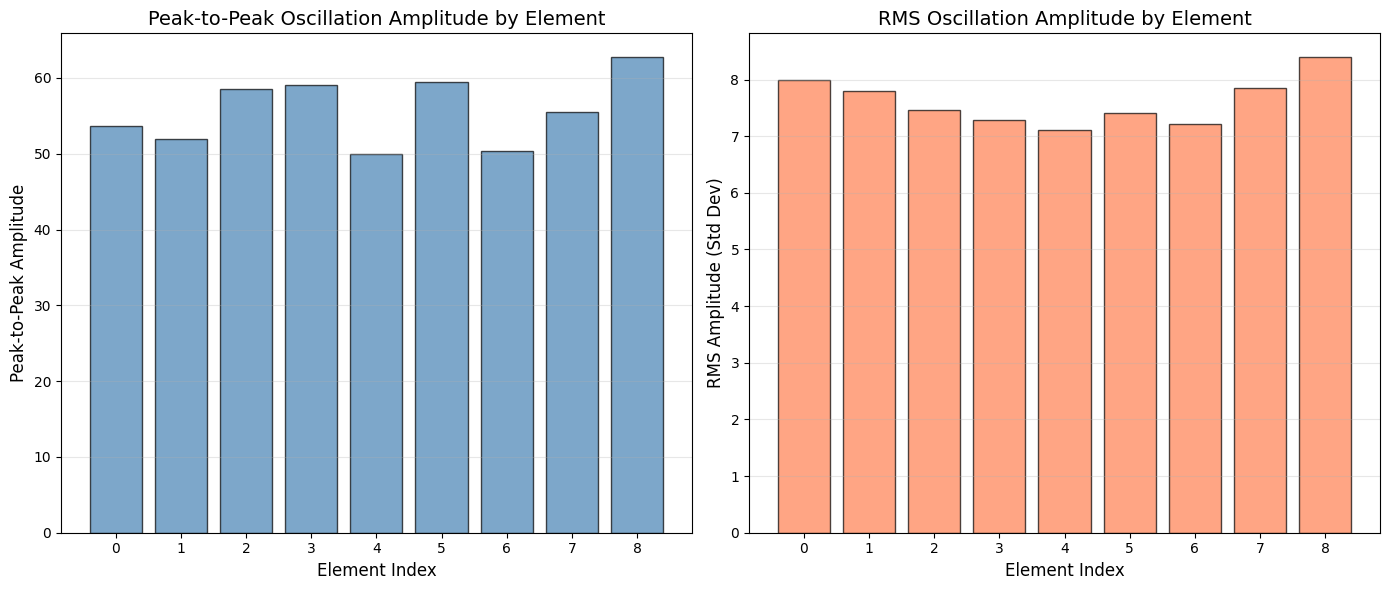

In [16]:
# Calculate oscillation amplitude for each element
if len(env.state_dict['curvature']) > 0:
    print("=" * 80)
    print("OSCILLATION AMPLITUDE ANALYSIS FOR EACH ELEMENT")
    print("=" * 80)
    print(f"{'Element':<10} {'Mean':<15} {'Peak-to-Peak':<15} {'RMS Amplitude':<15} {'Max':<15} {'Min':<15}")
    print("-" * 80)
    
    amplitudes_peak_to_peak = {}
    amplitudes_rms = {}
    means = {}
    
    for idx in element_indices:
        curvature_array = np.array(curvature_by_element[idx])
        
        # Calculate statistics
        mean_val = np.mean(curvature_array)
        max_val = np.max(curvature_array)
        min_val = np.min(curvature_array)
        peak_to_peak = max_val - min_val
        rms_amplitude = np.std(curvature_array)  # RMS amplitude (standard deviation)
        
        # Store for plotting
        amplitudes_peak_to_peak[idx] = peak_to_peak
        amplitudes_rms[idx] = rms_amplitude
        means[idx] = mean_val
        
        # Print results
        print(f"{idx:<10} {mean_val:<15.6f} {peak_to_peak:<15.6f} {rms_amplitude:<15.6f} {max_val:<15.6f} {min_val:<15.6f}")
    
    print("=" * 80)
    print("\nNote: RMS Amplitude = standard deviation (measure of oscillation around mean)")
    print("      Peak-to-Peak = maximum - minimum (full range of oscillation)")
    print("=" * 80)
    
    # Visualize amplitudes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Peak-to-Peak Amplitude
    elements = list(amplitudes_peak_to_peak.keys())
    peak_to_peak_vals = [amplitudes_peak_to_peak[idx] for idx in elements]
    ax1.bar(elements, peak_to_peak_vals, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Element Index', fontsize=12)
    ax1.set_ylabel('Peak-to-Peak Amplitude', fontsize=12)
    ax1.set_title('Peak-to-Peak Oscillation Amplitude by Element', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticks(elements)
    
    # Plot 2: RMS Amplitude
    rms_vals = [amplitudes_rms[idx] for idx in elements]
    ax2.bar(elements, rms_vals, alpha=0.7, color='coral', edgecolor='black')
    ax2.set_xlabel('Element Index', fontsize=12)
    ax2.set_ylabel('RMS Amplitude (Std Dev)', fontsize=12)
    ax2.set_title('RMS Oscillation Amplitude by Element', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(elements)
    
    plt.tight_layout()
    plt.show()
    
    # Store results in a dictionary for further analysis
    amplitude_results = {
        'element_indices': elements,
        'peak_to_peak': amplitudes_peak_to_peak,
        'rms_amplitude': amplitudes_rms,
        'means': means
    }
    
else:
    print("No curvature data available")



In [8]:

# plt.plot(env.state_dict['time'], env.state_dict['reward'])


# Visualize current snake shape
# v1.current_shape_3d(env.shearable_rod)

# Plot video from callback data
# v1.plot_video(env.callback_data)

v1.plot_video_auto_limits(
    env.callback_data,
    "video_auto_limits.mp4",
    1500,
)



Plotting limited video: using 65 of 65 frames, 60.63 fps, 1.07 seconds duration


100%|██████████| 64/64 [00:01<00:00, 60.27it/s]
